<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/Phase10_2_Purkinje_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np

# Path to the neuron SWC file
swc_path = '/content/drive/MyDrive/SRL/neurons/Ctrl-1_PC1.CNG.swc'

# Load the SWC file
cols = ['n', 'type', 'x', 'y', 'z', 'radius', 'parent']
df = pd.read_csv(swc_path, sep='\s+', comment='#', names=cols, dtype=float)

# Use first point as soma/root
soma_x, soma_y = df.iloc[0]['x'], df.iloc[0]['y']

# Normalize coordinates
df['x_centered'] = df['x'] - soma_x
df['y_centered'] = df['y'] - soma_y

# Convert to polar coordinates
df['r'] = np.sqrt(df['x_centered']**2 + df['y_centered']**2)
df['theta'] = np.arctan2(df['y_centered'], df['x_centered'])

# Remove points near the soma to avoid log(0)
df = df[df['r'] > 5]
df_sorted = df.sort_values(by='r')
r_vals = df_sorted['r'].values
theta_vals = df_sorted['theta'].values

print(f"Loaded {len(r_vals)} dendritic nodes for spiral fitting.")

Loaded 1401 dendritic nodes for spiral fitting.


In [9]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define SRL model
def spiral_model(r, omega, n, epsilon):
    return (-omega / n) * np.log(r + epsilon)

# Fit SRL to data
bounds = ([0.1, 1, 1e-5], [20, 20, 50])
popt, _ = curve_fit(spiral_model, r_vals, theta_vals, p0=[1.0, 4, 1e-2], bounds=bounds)
omega_fit, n_fit, epsilon_fit = popt

print(f"SRL Fit Results:")
print(f"  ω = {omega_fit:.4f}")
print(f"  n = {n_fit:.4f}")
print(f"  ε = {epsilon_fit:.6f}")

SRL Fit Results:
  ω = 0.1000
  n = 20.0000
  ε = 0.000010


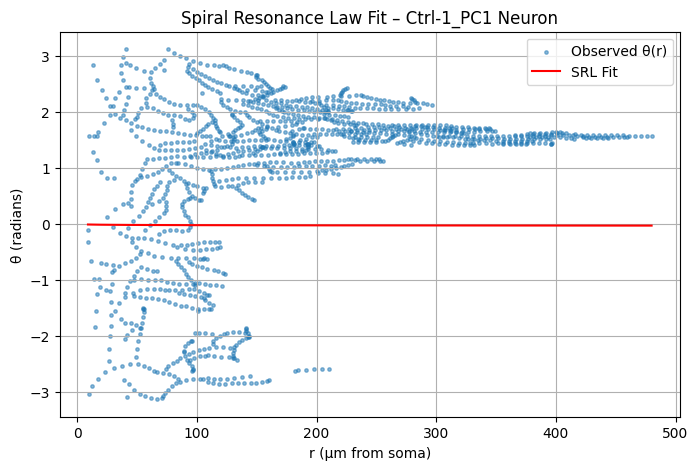

In [10]:
theta_pred = spiral_model(r_vals, *popt)

plt.figure(figsize=(8, 5))
plt.scatter(r_vals, theta_vals, s=6, alpha=0.5, label='Observed θ(r)')
plt.plot(r_vals, theta_pred, color='red', label='SRL Fit')
plt.xlabel('r (μm from soma)')
plt.ylabel('θ (radians)')
plt.title('Spiral Resonance Law Fit – Ctrl-1_PC1 Neuron')
plt.legend()
plt.grid(True)
plt.show()

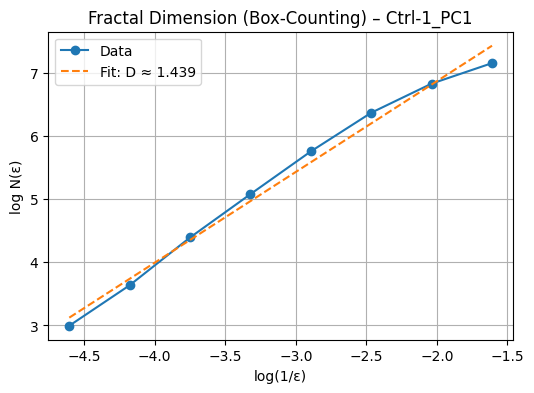

Estimated Fractal Dimension: D ≈ 1.439


In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Use 2D coordinates from SWC
x = df['x_centered'].values
y = df['y_centered'].values
points = np.vstack((x, y)).T

# Box-counting method
def box_count(points, box_sizes):
    counts = []
    for size in box_sizes:
        bins = [np.arange(min(points[:, i]), max(points[:, i]) + size, size) for i in range(2)]
        H, _, _ = np.histogram2d(points[:, 0], points[:, 1], bins=bins)
        counts.append(np.sum(H > 0))
    return counts

# Define box sizes (powers of 2)
epsilons = np.logspace(np.log10(5), np.log10(100), num=8)[::-1]  # from coarse to fine
counts = box_count(points, epsilons)

# Log-log plot
log_eps = np.log(1 / epsilons)
log_counts = np.log(counts)

# Linear fit
reg = LinearRegression().fit(log_eps.reshape(-1, 1), log_counts)
D = reg.coef_[0]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(log_eps, log_counts, 'o-', label='Data')
plt.plot(log_eps, reg.predict(log_eps.reshape(-1, 1)), '--', label=f'Fit: D ≈ {D:.3f}')
plt.xlabel('log(1/ε)')
plt.ylabel('log N(ε)')
plt.title('Fractal Dimension (Box-Counting) – Ctrl-1_PC1')
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated Fractal Dimension: D ≈ {D:.3f}")